# Guardians of the Memory - Modeling - Felix

**Contents**:
1. Preprocessing and feature engineering
2. Modeling
    * 2.1. Defining functions
    * 2.2. XGBoost Classifier
    * 2.3. GaussianNB
    * 2.4. Isolation Forest
    * 2.5. Artificial Neural Network
    * 2.6. Stacking
3. Model export
4. Error analysis

### Import Libraries

In [1]:
import warnings # Turn off warnings
warnings.filterwarnings('ignore')

import os # Import own functions
import sys
sys.path.append("..") # Fix folder structure
from src.hdd_preprocessing import load_preprocess_data, train_test_splitter, calculate_target
from src.hdd_feature_engineering import log_transformer, hdd_preprocessor

import pandas as pd # Pandas and Numpy
import numpy as np

import mlflow # MLFlow for experiment tracking
EXPERIMENT_NAME = "guardians_of_the_memory_felix"
# TRACKING_URI = open("../.mlflow_uri").read().strip()

import seaborn as sns # Plotting libraries
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Sklearn for preprocessing and modeling
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest, StackingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

# Sklearn metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, fbeta_score
from sklearn.metrics import make_scorer, precision_recall_curve, mean_squared_error

# Tensorflow and Keras
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.metrics import Recall, Precision
from keras import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from mlflow.sklearn import save_model

RSEED = 42 # Random seed for repeatability

# 1. Preprocessing and feature engineering


* We load the file containing the history 2019-2021 of the picked model.
* The target is calculated, then the data is preprocessed (dropping columns, dropping NaN rows and duplicate rows)
* We train-test split the data to prevent leakage during feature engineering. The data is split according to serial numbers (so all history of one drives ends up in either the train or the test set)
* The preprocessor generates the features. Although the first call uses `fit`, nothing is fitted here.
* Next we define a pipeline for scaling. We use our custom log_transformer and scale the data using MinMaxScaling.

In [2]:
repo_path = os.getcwd()+"/../" # Path to the parent directory
# Loading and preprocessing of the data
X, y = load_preprocess_data(days=30, filename="ST4000DM000_history_total", path=repo_path)
df_backup = X.copy() # Backup the original data
# Train-test split according to serial numbers
X_train, X_test, y_train, y_test = train_test_splitter(
        X, y, test_size=0.30, random_state=RSEED
        )
# Feature engineering
feat_eng = hdd_preprocessor(days=30, trigger=0.05)
X_train = feat_eng.fit_transform(X_train)
X_test = feat_eng.transform(X_test)
# Defing scaling pipeline
scaling_pipe = Pipeline([
                ('scaler_log', log_transformer(offset=1)),
                ('scaler_minmax ', MinMaxScaler()),
                ])

In [3]:
X_train.columns

Index(['smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_192_raw', 'smart_193_raw',
       'smart_197_raw', 'smart_198_raw', 'smart_199_raw', 'smart_240_raw',
       'smart_241_raw', 'smart_242_raw', 'smart_999'],
      dtype='object')

# 2. Modeling

The main modeling section. We model using different approaches and compare the results. Finally, we use stacking to hopefully beat the individual models.
1. Defining functions
2. XGBoost Classifier
3. Gaussian Naive Bayes
4. Isolation Forest
5. Artificial Neural Network
6. Stacking

## 2.1. Defining functions

Here, we define helper functions for train, evaluation and plotting. Additionally, we define custom scorers sklearn.

In [4]:
def train_eval_model(model, X_train, X_test, y_train, y_test):
        """Train the model, make predictions and evaluate the model

        Args:
            model (_type_): Model including hyperparameters
            X_train (_type_): X_train
            X_test (_type_): X_test
            y_train (_type_): y_train
            y_test (_type_): y_test

        Returns:
            _type_: Fitted model, predictions and probabilities
        """
        print("Fitting")
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_pred = model.predict(X_test)
        y_train_proba = model.predict_proba(X_train)
        y_proba = model.predict_proba(X_test)
        fbeta_test = fbeta_score(y_test, y_pred, beta=2).round(2)
        auc_test = roc_auc_score(y_test, y_proba[:,1]).round(2)
        recall_test = recall_score(y_test, y_pred).round(2)
        fbeta_train = fbeta_score(y_train, y_train_pred, beta=2).round(2)
        auc_train = roc_auc_score(y_train, y_train_proba[:,1]).round(2)
        recall_train = recall_score(y_train, y_train_pred).round(2)
        print("---------------------------------------------------")
        print("Model evaluation")
        print("F2 score test (train):", fbeta_test, "(", fbeta_train, ")")
        print("Area under the ROC curve test (train):", auc_test, "(", auc_train, ")")
        print("Recall test (train):", recall_test, "(", recall_train, ")")
        print("---------------------------------------------------")
        return model, y_pred, y_proba[:,1]

def plot_pr_curve(y_test, y_pred_proba):
        """Plot the precision recall curve and the f2 curve

        Args:
            y_test (_type_): Predictions
            y_pred_proba (_type_): Predicted probabilities

        Returns:
            _type_: F2 scores and the threshold of maximum F2
        """

        pre, rec, thresholds1 = precision_recall_curve(y_test, y_pred_proba)
        f2 = (5)*(pre*rec)/(4*pre + rec)
        plt.plot(thresholds1, pre[1:],'r-',label = 'Precision Model')
        plt.plot(thresholds1, rec[1:],'b-',label = 'Recall Model')
        plt.plot(thresholds1, f2[1:],'g-',label = 'f2 Model')
        plt.legend()
        plt.xlabel('Threshold')
        plt.ylabel('Metrics')
        plt.show()
        idx = np.nanargmax(f2)
        return f2, thresholds1[idx]

def predict_threshold(y_pred_proba, threshold=0.5):
        """Make predictions based on a threshold

        Args:
            y_pred_proba (_type_): Predicted probabilities
            threshold (float, optional): Threshold. Defaults to 0.5.

        Returns:
            _type_: _description_
        """
        return y_pred_proba > threshold

def eval_model(y_true, y_pred, y_proba):
        """Calculate the scores of the model

        Args:
            y_true (_type_): True labels
            y_pred (_type_): Predicted labels
            y_proba (_type_): Predicted probabilities
        """
        fbeta_test = fbeta_score(y_true, y_pred, beta=2).round(2)
        auc_test = roc_auc_score(y_true, y_proba).round(2)
        recall_test = recall_score(y_true, y_pred).round(2)
        print("F2 score test:", fbeta_test)
        print("Area under the ROC curve test:", auc_test)
        print("Recall test:", recall_test)
        return

ftwo_scorer = make_scorer(fbeta_score, beta=2)

## 2.2 XGBOOST Classification

[Nice manual I followed](http://ethen8181.github.io/machine-learning/trees/xgboost.html)

Fitting
[11:04:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
---------------------------------------------------
Model evaluation
F2 score test (train): 0.43 ( 0.5 )
Area under the ROC curve test (train): 0.83 ( 0.91 )
Recall test (train): 0.58 ( 0.57 )
---------------------------------------------------


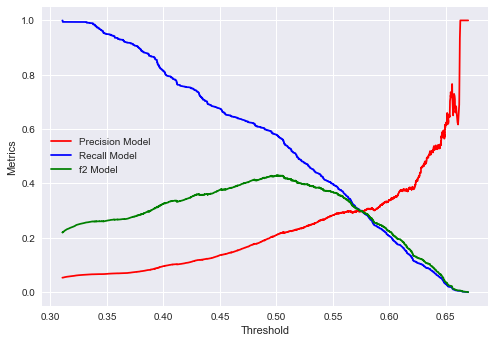

F2 score test: 0.43
Area under the ROC curve test: 0.83
Recall test: 0.57


In [5]:
# Define the model
model = XGBClassifier( objective="binary:logistic",
              scale_pos_weight=0.4*len(y_train)/y_train.sum(), # ratio of number of negative class to the positive class
              colsample_bytree=0.4, # 1, Number of features used by tree, lower to regularize
              subsample=0.3, # 1, ratio of the training instances used, lower to regularize
              eta=0.01, # 0.3, learning rate, lower values to regularize
              gamma=1, # 0, regularization parameter, higher to regularize
              max_depth=6, # 6, maximum tree depth
              n_estimators=50 , # 100, number of trees to grow
              min_child_weight=2 , # 1, minimum sum of instance weight needed in a leaf, higher to regularize
              reg_lambda=0.7, # 1, L2 regularization
              reg_alpha=1, # 0, L1 regularization
              use_label_encoder=False,
              )
pipe = Pipeline([
              ('scaling', scaling_pipe),
              ('model', model),
              ])
# Fit and evaluate the model
pipe_xgb, y_pred, y_proba = train_eval_model(pipe, X_train, X_test, y_train, y_test)
# Plot the precision recall curve
_, threshold = plot_pr_curve(y_test, y_proba)
# Adjust the thrshold and evaluate the model
y_pred_t = predict_threshold(y_proba, threshold)
eval_model(y_true=y_test, y_pred=y_pred_t, y_proba=y_proba)

### 2.2.1 GridSearch

Fitting


/Users/felix/ds-projects-capstone/.venv/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/felix/ds-projects-capstone/.venv/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/felix/ds-projects-capstone/.venv/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/felix/ds-projects-capstone/.venv/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecate

[11:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the o

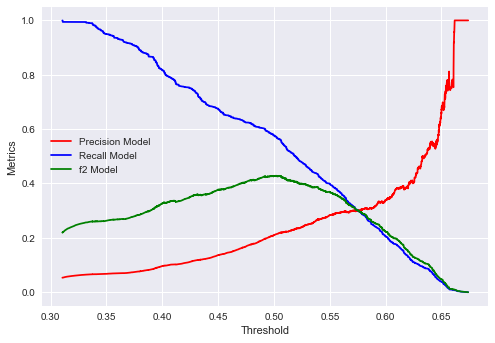

F2 score test: 0.43
Area under the ROC curve test: 0.83
Recall test: 0.57


In [6]:
# Parameter grid for gridsearch
param_grid = { "model__colsample_bytree": [0.4], # 1, Number of features used by tree, lower to regularize
                "model__subsample": [0.3], # 1, ratio of the training instances used, lower to regularize
                "model__eta": [0.01], # 0.3, learning rate, lower values to regularize
                "model__gamma": [0, 1, 10, 100, 1000], # 0, regularization parameter, higher to regularize
                "model__max_depth": [6], # 6, maximum tree depth
                "model__n_estimators": [50] , # 100, number of trees to grow
                "model__min_child_weight": [2] , # 1, minimum sum of instance weight needed in a leaf, higher to regularize
                "model__reg_lambda": [0.7], # 1, L2 regularization
                "model__reg_alpha": [0, 0.5, 1, 10], # 0, L1 regularization
                }
# Define GridSearch object
grid_search = GridSearchCV(pipe_xgb, param_grid, scoring=ftwo_scorer,
                            cv=10, verbose=0, n_jobs=-1)
# Fit and evaluate the model
grid_search_xgb, y_pred, y_proba = train_eval_model(grid_search, X_train, X_test, y_train, y_test)
# Plot the precision recall curve
_, threshold = plot_pr_curve(y_test, y_proba)
# Adjust the thrshold and evaluate the model
y_pred_t = predict_threshold(y_proba, threshold)
eval_model(y_true=y_test, y_pred=y_pred_t, y_proba=y_proba)

<AxesSubplot:xlabel='param_model__gamma', ylabel='mean_test_score'>

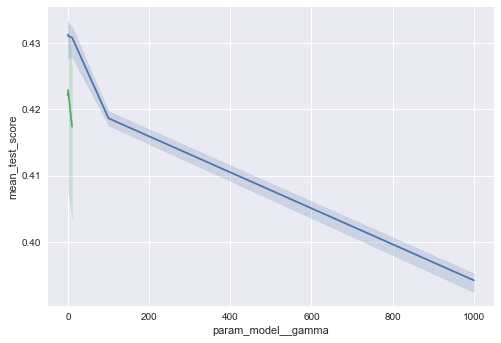

In [7]:
cv_results = pd.DataFrame(grid_search_xgb.cv_results_)
sns.lineplot(x=cv_results.param_model__gamma, y=cv_results.mean_test_score)
sns.lineplot(x=cv_results.param_model__reg_alpha, y=cv_results.mean_test_score)

<AxesSubplot:xlabel='param_model__reg_alpha', ylabel='param_model__gamma'>

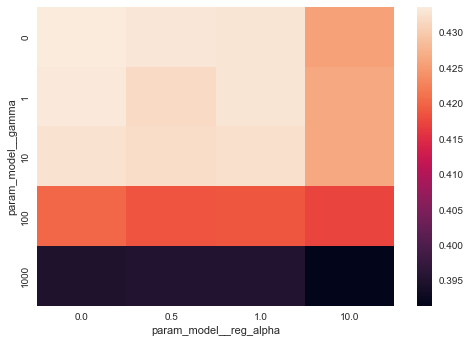

In [8]:
sns.heatmap(cv_results.pivot("param_model__gamma", "param_model__reg_alpha", "mean_test_score"))

### 2.2.2 Additional plots

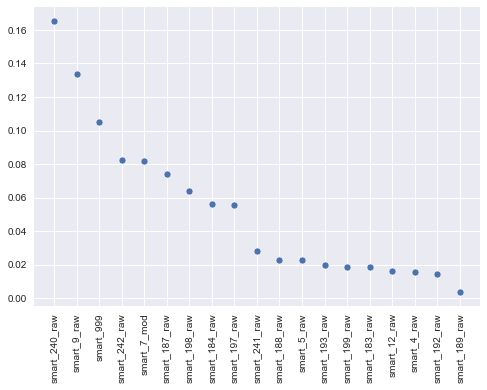

In [9]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.scatterplot(data=feat_importances)
plt.xticks(rotation=90);

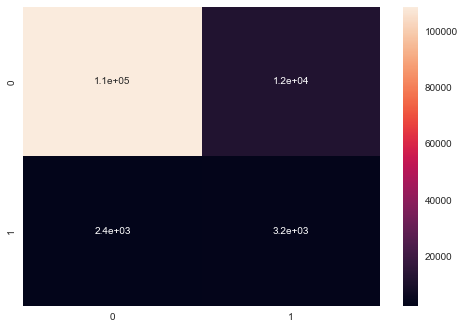

In [10]:
sns.heatmap(confusion_matrix(y_test, y_pred_t), annot=True);

## 2.3. Naive Bayes

Fitting
---------------------------------------------------
Model evaluation
F2 score test (train): 0.37 ( 0.38 )
Area under the ROC curve test (train): 0.8 ( 0.84 )
Recall test (train): 0.5 ( 0.47 )
---------------------------------------------------


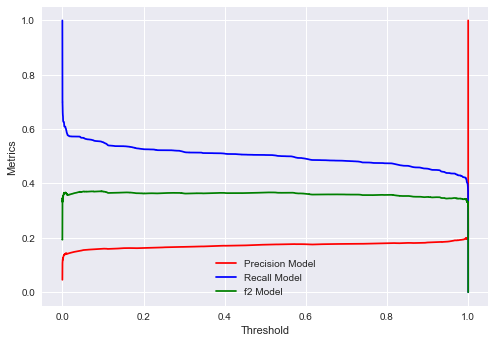

F2 score test: 0.37
Area under the ROC curve test: 0.8
Recall test: 0.55


In [11]:
# Define the model
model = GaussianNB(var_smoothing=1e-8, 
              priors=[1/(0.4*len(y_train)/y_train.sum()), 1-1/(0.4*len(y_train)/y_train.sum())],
              )
pipe = Pipeline([
              ('scaling', scaling_pipe),
              ('model', model),
              ])
# Fit and evaluate the model
pipe_nb, y_pred, y_proba = train_eval_model(pipe, X_train, X_test, y_train, y_test)
# Plot the precision recall curve
_, threshold = plot_pr_curve(y_test, y_proba)
# Adjust the thrshold and evaluate the model
y_pred_t = predict_threshold(y_proba, threshold)
eval_model(y_true=y_test, y_pred=y_pred_t, y_proba=y_proba)

### 2.3.1 GridSearch

Fitting
---------------------------------------------------
Model evaluation
F2 score test (train): 0.32 ( 0.36 )
Area under the ROC curve test (train): 0.8 ( 0.83 )
Recall test (train): 0.77 ( 0.76 )
---------------------------------------------------


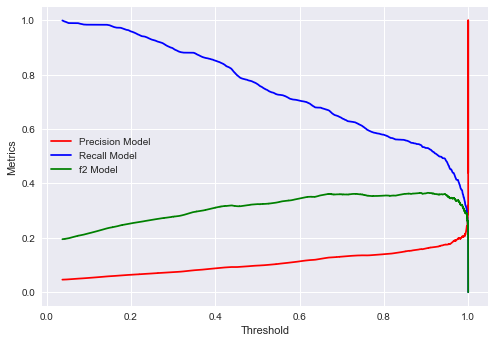

F2 score test: 0.37
Area under the ROC curve test: 0.8
Recall test: 0.53


In [12]:
# Parameter grid for gridsearch
param_grid = { "model__var_smoothing": np.exp(np.linspace(-15,5)),
                     # "priors": [None],
                     }
# Define GridSearch object
grid_search = GridSearchCV(pipe_nb, param_grid, scoring=ftwo_scorer,
                            cv=10, verbose=0, n_jobs=-1)
# Fit and evaluate the model
grid_search_nb, y_pred, y_proba = train_eval_model(grid_search, X_train, X_test, y_train, y_test)
# Plot the precision recall curve
_, threshold = plot_pr_curve(y_test, y_proba)
# Adjust the thrshold and evaluate the model
y_pred_t = predict_threshold(y_proba, threshold)
eval_model(y_true=y_test, y_pred=y_pred_t, y_proba=y_proba)

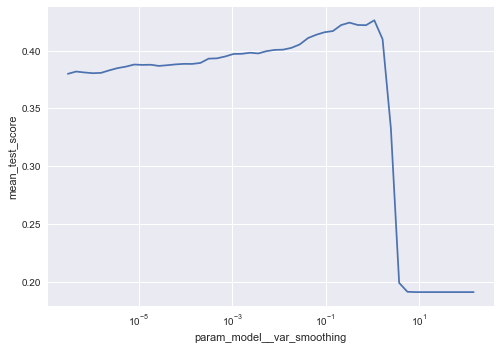

In [13]:
sns.lineplot(data=pd.DataFrame(grid_search_nb.cv_results_),
                x="param_model__var_smoothing",
                y="mean_test_score")
plt.xscale("log")

## 2.4. Isolation Forest

Since Isolation Forests are used for outlier detection, it will output -1 or 1 indicating if the observation is an outlier or not. The `decision_function` returns the anomaly score in the range between -1 and 1. This can be seen as a probability. We shift and scale the predictions and probabilities to be able to use our evaluation metrics and functions.

Training metrics
F2 score test: 0.34
Area under the ROC curve test: 0.75
Recall test: 0.61
Test metrics
F2 score test: 0.33
Area under the ROC curve test: 0.75
Recall test: 0.66


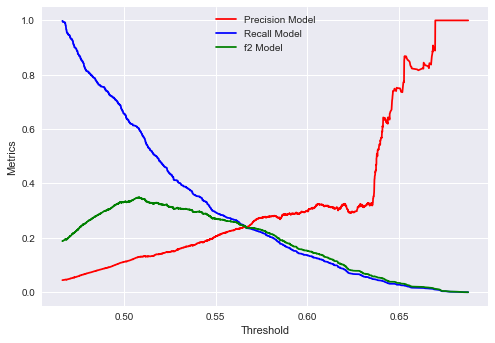

F2 score test: 0.35
Area under the ROC curve test: 0.75
Recall test: 0.6


In [14]:
# Define the model
model = IsolationForest(contamination=5*(y_train.sum()/len(y_train)))
pipe = Pipeline([
              ('scaling', scaling_pipe),
              ('model', model),
              ])
# Fit and evaluate the model
y_pred_train = -1/2*(model.fit_predict(X_train) - 1)
y_pred = -1/2*(model.predict(X_test) - 1)
y_proba = -1/2*(model.decision_function(X_test) - 1)
y_proba_train = -1/2*(model.decision_function(X_train) - 1)
print("Training metrics")
eval_model(y_true=y_train, y_pred=y_pred_train, y_proba=y_proba_train)
print("Test metrics")
eval_model(y_true=y_test, y_pred=y_pred, y_proba=y_proba)
_, threshold = plot_pr_curve(y_test, y_proba)
# Adjust the thrshold and evaluate the model
y_pred_t = predict_threshold(y_proba, threshold)
eval_model(y_true=y_test, y_pred=y_pred_t, y_proba=y_proba)

## 2.5 Artificial Neural Network

Build function needed for the Keras Scikit-Learn Wrapper

In [15]:
def create_ann_model(input_dim=19):
        # initiate the instance
        model = Sequential()
        # layers
        model.add(Dense(units = 30, kernel_initializer = 'uniform', activation = 'relu', input_dim=input_dim))
        model.add(Dropout(0.2))
        model.add(Dense(units = 30, kernel_initializer = 'uniform', activation = 'relu'))
        model.add(Dropout(0.2))
        model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
        # compiling the ANN
        model.compile(optimizer = 'adam', 
                        loss = 'binary_crossentropy', 
                        metrics = ['Recall', 'Precision'])
        return model

Fitting


2022-04-21 11:13:56.370166: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


---------------------------------------------------
Model evaluation
F2 score test (train): 0.44 ( 0.44 )
Area under the ROC curve test (train): 0.83 ( 0.87 )
Recall test (train): 0.62 ( 0.54 )
---------------------------------------------------


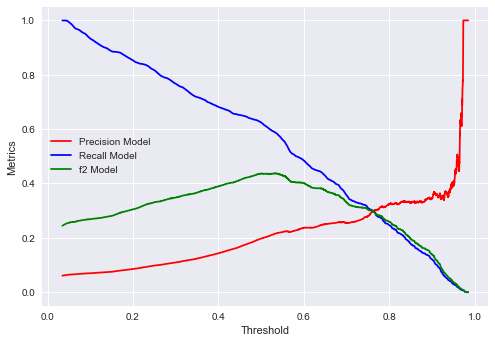

F2 score test: 0.44
Area under the ROC curve test: 0.83
Recall test: 0.59


In [16]:
# Define the model
model = KerasClassifier(build_fn=create_ann_model, 
            epochs=150,
            batch_size= 40000,
            class_weight={0 : 1.0, 1 : 0.4*len(y_train)/y_train.sum()},
            verbose=0,
            )
model._estimator_type = "classifier"
pipe = Pipeline([
              ('scaling', scaling_pipe),
              ('model', model),
              ])
# Fit and evaluate the model
pipe_ann, y_pred, y_proba = train_eval_model(pipe, X_train, X_test, y_train, y_test)
# Plot the precision recall curve
_, threshold = plot_pr_curve(y_test, y_proba)
# Adjust the thrshold and evaluate the model
y_pred_t = predict_threshold(y_proba, threshold)
eval_model(y_true=y_test, y_pred=y_pred_t, y_proba=y_proba)

## 2.6 Stacking

Fitting
[11:14:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2022-04-21 11:14:35.923516: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-21 11:14:56.877555: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
[11:14:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:14:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'er

---------------------------------------------------
Model evaluation
F2 score test (train): 0.0 ( 0.0 )
Area under the ROC curve test (train): 0.83 ( 0.88 )
Recall test (train): 0.0 ( 0.0 )
---------------------------------------------------


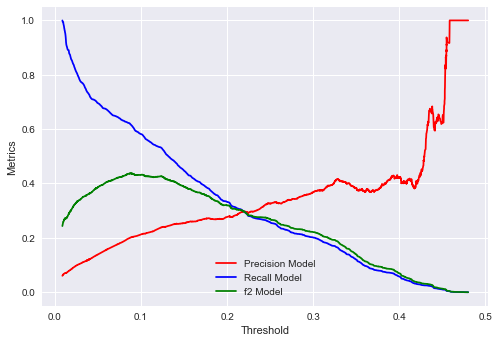

F2 score test: 0.44
Area under the ROC curve test: 0.83
Recall test: 0.62


In [17]:
# Define the individual model
model_ann = KerasClassifier(build_fn=create_ann_model, 
                epochs=150,
                batch_size= 40000,
                class_weight={0 : 1.0, 1 : 0.4*len(y_train)/y_train.sum()},
                verbose=0,
                )
model_ann._estimator_type = "classifier"
model_xgb = XGBClassifier( objective="binary:logistic",
                scale_pos_weight=0.4*len(y_train)/y_train.sum(), # ratio of number of negative class to the positive class
                colsample_bytree=0.4, # 1, Number of features used by tree, lower to regularize
                subsample=0.3, # 1, ratio of the training instances used, lower to regularize
                eta=0.01, # 0.3, learning rate, lower values to regularize
                gamma=1, # 0, regularization parameter, higher to regularize
                max_depth=6, # 6, maximum tree depth
                n_estimators=50 , # 100, number of trees to grow
                min_child_weight=2 , # 1, minimum sum of instance weight needed in a leaf, higher to regularize
                reg_lambda=0.7, # 1, L2 regularization
                reg_alpha=1, # 0, L1 regularization
                use_label_encoder=False,
                )
# Put them together
estimators = [("xgb", model_xgb),
                ("ann", model_ann),
                ]
# Define the StackingClassifier
model = StackingClassifier(estimators = estimators, 
            final_estimator=LogisticRegression(class_weight=0.4*len(y_train)/y_train.sum()),
            n_jobs=-1,
            )
# Put together pipeline
pipe = Pipeline([
              ('scaling', scaling_pipe),
              ('model', model),
              ])
# Fit and evaluate the model
pipe_dep, y_pred, y_proba = train_eval_model(pipe, X_train, X_test, y_train, y_test)
# Plot the precision recall curve
_, threshold = plot_pr_curve(y_test, y_proba)
# Adjust the threshold and evaluate the model
y_pred_t = predict_threshold(y_proba, threshold)
eval_model(y_true=y_test, y_pred=y_pred_t, y_proba=y_proba)

In [18]:
threshold

0.08698228942184147

# 3. Model export

In [19]:
# Save using pickle
# filename = 'deployment.bin'
# with open(filename, 'wb') as file_out:
#     pickle.dump(model, file_out)
# Saving using mlflow.sklearn save_model
path = "../models/deployment_ann"
save_model(sk_model=pipe_ann, path=path)

2022-04-21 11:16:21.732348: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://592b4d40-b088-4c94-aec9-1cac6cb39032/assets


# 4. Error Analysis

In addition to the confusion matrix, we have a look how the probabilities are distributed for True and False observations. False negatives are referred to as silent deaths since those HDDs fail without warning. We will have a look at that to find the limits of our model.

First we specify the model to use and recalculate the predictions.

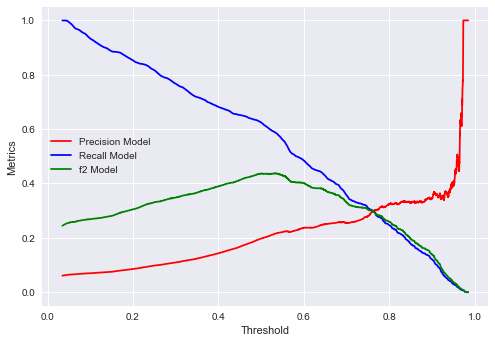

Adjusted threshold: 0.5320059


In [20]:
# Specify model to use
model = pipe_ann
# Recalculate predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]
# Adjust threshold
_, threshold = plot_pr_curve(y_test, y_proba)
print("Adjusted threshold:", threshold)
y_pred = predict_threshold(y_proba, threshold)
# Restore the original indices
y_pred = pd.Series(y_pred, index=y_test.index)
y_proba = pd.Series(y_proba, index=y_test.index)

In the following plot, we look at the distribution of predicted probabilities for both classes. Green are failing drives and blue are healthy drives.

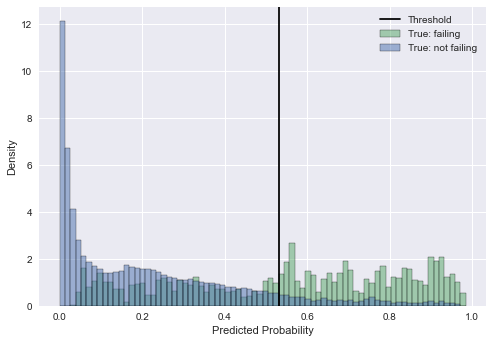

In [21]:
#sns.histplot(x=y_proba[y_test == 1], hue=y_test[y_test == 1], bins=50)
#plt.axvline(x=threshold, c='k')
#plt.figure()
#sns.histplot(x=y_proba[y_test == 0], hue=y_test[y_test == 0], bins=50)
sns.histplot(x=y_proba, hue=y_test, stat="density", common_norm=False)#, alpha=0.4)
plt.axvline(x=threshold, c='k')
plt.legend(["Threshold", "True: failing", "True: not failing"])
plt.xlabel("Predicted Probability");

Select silent deaths (false negative)

In [22]:
X_true = X_test[y_test==1]
X_true[y_proba[X_true.index] < 0.4]

,smart_4_raw,smart_5_raw,smart_7_mod,smart_9_raw,smart_12_raw,smart_183_raw,smart_184_raw,smart_187_raw,smart_188_raw,smart_189_raw,smart_192_raw,smart_193_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,smart_999
89,10.0,0.0,1.190838e+09,46383.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,156425.0,0.0,0.0,0.0,45662.0,5.871058e+10,2.429026e+11,0
95,15.0,0.0,1.435393e+09,42858.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,8322.0,0.0,0.0,0.0,42786.0,5.960061e+10,2.364565e+11,0
186,23.0,0.0,1.128100e+09,34639.0,23.0,29.0,0.0,15.0,0.0,0.0,0.0,2259.0,0.0,0.0,0.0,34627.0,3.535417e+10,4.537037e+11,0
274,7.0,0.0,1.716994e+09,44457.0,7.0,1.0,0.0,0.0,0.0,0.0,1.0,22742.0,0.0,0.0,0.0,44326.0,6.475991e+10,6.638822e+11,0
306,7.0,0.0,1.197944e+09,38957.0,7.0,3.0,0.0,0.0,0.0,0.0,0.0,9334.0,0.0,0.0,0.0,38765.0,5.343447e+10,2.410269e+11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462491,17.0,0.0,1.678253e+09,44020.0,17.0,2.0,0.0,31.0,0.0,0.0,1.0,10455.0,8.0,8.0,0.0,43910.0,6.301724e+10,3.428503e+11,0
462725,10.0,0.0,1.210700e+09,46666.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,156425.0,0.0,0.0,0.0,45945.0,5.892475e+10,2.454912e+11,0
462731,15.0,0.0,1.457182e+09,43146.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,8322.0,0.0,0.0,0.0,43073.0,5.976504e+10,2.394892e+11,0
462809,23.0,0.0,1.141047e+09,34925.0,23.0,29.0,0.0,15.0,0.0,0.0,0.0,2260.0,0.0,0.0,0.0,34913.0,3.559751e+10,4.605149e+11,0
